<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/convnets/vgg_net(original_paper_implementation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

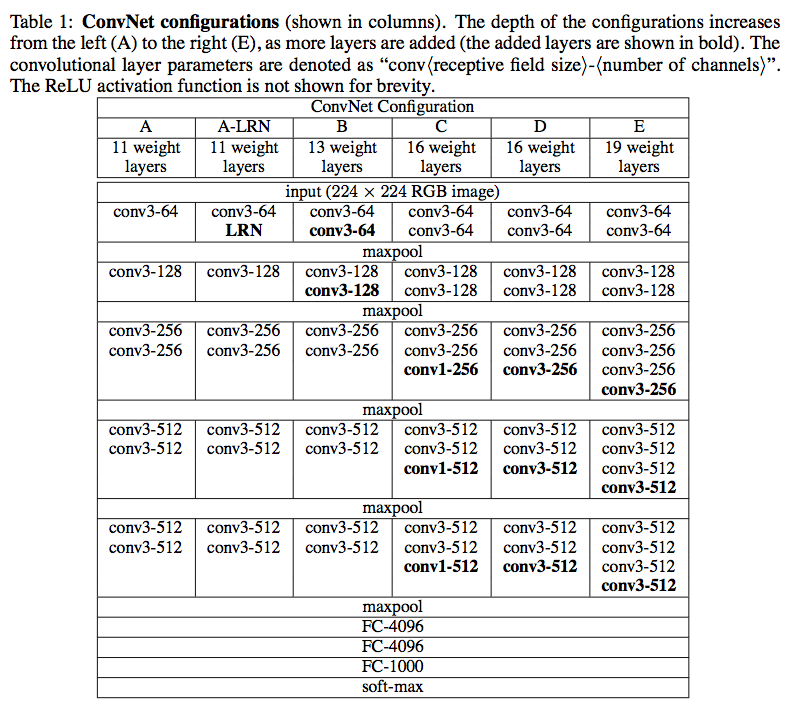

In [ ]:
import torch
import torch.nn as nn

In [ ]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M"],
    "VGG19": [64,64,"M",128,128,"M",256,256,256,256,"M",512,512,512,512,"M",512,512,512,512,"M",
    ],
}

In [ ]:
class VGG_net(nn.Module):
    def __init__(self,vgg_type,in_channels = 3,num_classes = 10): # in original paper no of classes = 1000
        super(VGG_net,self).__init__()
        self.in_channels = in_channels

        self.conv_layers = self.create_conv_layers(VGG_types[vgg_type])
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(p= 0.5),
            nn.Linear(4096,num_classes)
        )

    def forward(self,x):
        x = self.conv_layers(x)
        x = x.reshape(x.size(0),-1)
        x = self.fcs(x)
        return x
    def create_conv_layers(self,architecture):
        layers = []
        in_channels = self.in_channels
        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [
                    nn.Conv2d(in_channels,out_channels,kernel_size = (3,3),padding = (1,1),stride = (1,1)),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU()
                ]
                in_channels = out_channels
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size = (2,2),stride=(2,2))]
        return nn.Sequential(*layers)

In [ ]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg_11 = VGG_net('VGG11').to(device)
vgg_13 = VGG_net('VGG13').to(device)
vgg_16 = VGG_net('VGG16',in_channels=1).to(device)
vgg_19 = VGG_net('VGG19').to(device)


In [ ]:
# from torchsummary import summary

# summary(vgg_16,(3,224,224))

dummy example to test output shape

In [ ]:
x = torch.randn(3,3,224,224)
x = x.to(device)
vgg_19(x).shape

torch.Size([3, 10])

In [ ]:
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

epochs = 5
batch_size = 32

# the image transforms

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,std=0.5)
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,std=0.5)
])

# Datasets and Dataloaders

In [ ]:
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           download = True,
                                           transform = train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size,
                                               shuffle = True)
test_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = False,
                                           download = True,
                                           transform = test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = batch_size,
                                               shuffle = False)

Initialialize model,optimizer,loss function

In [ ]:
vgg_16 = VGG_net('VGG16',in_channels=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(),lr= 0.01,momentum = 0.9,weight_decay = 0.0005)

In [ ]:
from tqdm import tqdm

Training function

In [ ]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

Validation function

In [ ]:
def validate(model, testloader, criterion):
    model.eval()

    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            # calculate the accuracy for each class
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    # print the accuracy for each class after evey epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(10):
        print(f"Accuracy of digit {i}: {100*class_correct[i]/class_total[i]}")
    return epoch_loss, epoch_acc

In [ ]:
images,labels = next(iter(train_dataloader))
images.shape

torch.Size([32, 1, 224, 224])

In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(vgg_16, train_dataloader,
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(vgg_16, test_dataloader,
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 5
Training


100%|██████████| 1875/1875 [16:00<00:00,  1.95it/s]


Validation


100%|██████████| 313/313 [00:58<00:00,  5.37it/s]




Accuracy of digit 0: 98.46938775510205
Accuracy of digit 1: 98.8546255506608
Accuracy of digit 2: 98.74031007751938
Accuracy of digit 3: 99.5049504950495
Accuracy of digit 4: 93.38085539714868
Accuracy of digit 5: 98.4304932735426
Accuracy of digit 6: 99.37369519832986
Accuracy of digit 7: 97.56809338521401
Accuracy of digit 8: 99.38398357289527
Accuracy of digit 9: 97.7205153617443


Training loss: 0.282, training acc: 92.200
Validation loss: 0.061, validation acc: 98.150
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


100%|██████████| 1875/1875 [16:00<00:00,  1.95it/s]


Validation


100%|██████████| 313/313 [00:58<00:00,  5.36it/s]




Accuracy of digit 0: 99.6938775510204
Accuracy of digit 1: 99.03083700440529
Accuracy of digit 2: 99.70930232558139
Accuracy of digit 3: 99.60396039603961
Accuracy of digit 4: 97.04684317718942
Accuracy of digit 5: 98.4304932735426
Accuracy of digit 6: 99.26931106471817
Accuracy of digit 7: 98.92996108949416
Accuracy of digit 8: 98.25462012320328
Accuracy of digit 9: 98.41427155599604


Training loss: 0.082, training acc: 97.872
Validation loss: 0.042, validation acc: 98.850
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


100%|██████████| 1875/1875 [16:00<00:00,  1.95it/s]


Validation


100%|██████████| 313/313 [00:58<00:00,  5.37it/s]




Accuracy of digit 0: 99.89795918367346
Accuracy of digit 1: 99.91189427312776
Accuracy of digit 2: 99.2248062015504
Accuracy of digit 3: 99.10891089108911
Accuracy of digit 4: 99.4908350305499
Accuracy of digit 5: 99.43946188340807
Accuracy of digit 6: 99.06054279749478
Accuracy of digit 7: 99.41634241245136
Accuracy of digit 8: 98.15195071868582
Accuracy of digit 9: 97.7205153617443


Training loss: 0.057, training acc: 98.578
Validation loss: 0.032, validation acc: 99.150
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


100%|██████████| 1875/1875 [16:01<00:00,  1.95it/s]


Validation


100%|██████████| 313/313 [00:58<00:00,  5.39it/s]




Accuracy of digit 0: 99.79591836734694
Accuracy of digit 1: 100.0
Accuracy of digit 2: 99.90310077519379
Accuracy of digit 3: 99.3069306930693
Accuracy of digit 4: 99.4908350305499
Accuracy of digit 5: 99.43946188340807
Accuracy of digit 6: 98.32985386221294
Accuracy of digit 7: 99.0272373540856
Accuracy of digit 8: 98.870636550308
Accuracy of digit 9: 98.31516352824579


Training loss: 0.046, training acc: 98.805
Validation loss: 0.023, validation acc: 99.260
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


100%|██████████| 1875/1875 [16:01<00:00,  1.95it/s]


Validation


100%|██████████| 313/313 [00:58<00:00,  5.39it/s]



Accuracy of digit 0: 99.79591836734694
Accuracy of digit 1: 99.55947136563877
Accuracy of digit 2: 99.32170542635659
Accuracy of digit 3: 99.4059405940594
Accuracy of digit 4: 99.28716904276986
Accuracy of digit 5: 99.66367713004485
Accuracy of digit 6: 98.95615866388309
Accuracy of digit 7: 99.5136186770428
Accuracy of digit 8: 98.66529774127311
Accuracy of digit 9: 98.41427155599604


Training loss: 0.038, training acc: 99.002
Validation loss: 0.024, validation acc: 99.260
--------------------------------------------------


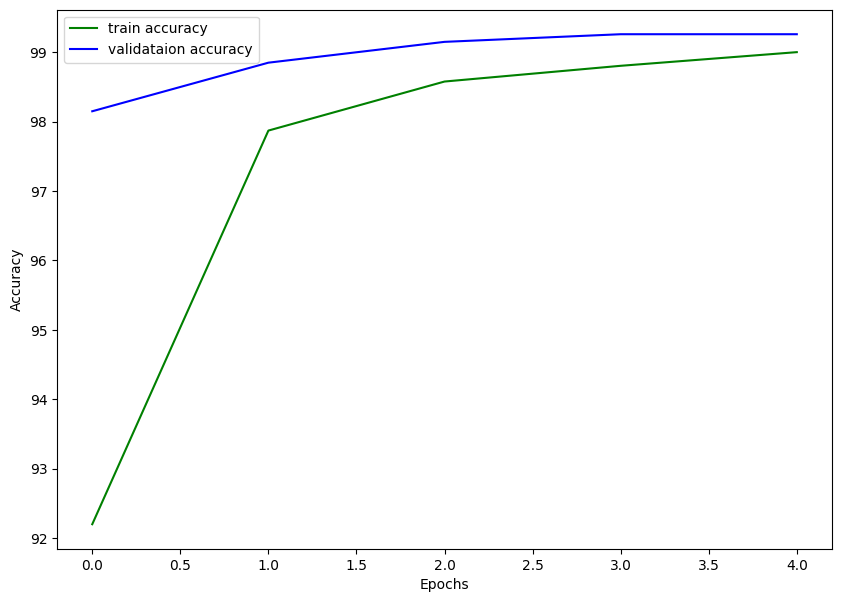

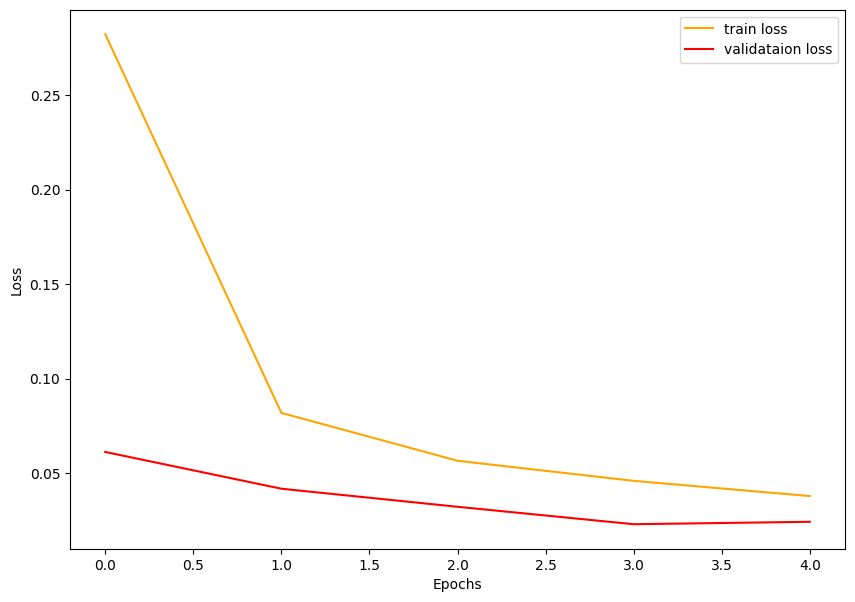

TRAINING COMPLETE


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-',
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-',
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('../outputs/accuracy.jpg')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-',
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-',
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/loss.jpg')
plt.show()

print('TRAINING COMPLETE')